In [1]:
!pip install gurobipy

     |████████████████████████████████| 11.5 MB 3.1 MB/s 


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

import seaborn as sns 
import gurobipy as gp


from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error as mse


In [3]:
df=pd.read_csv('training_data.csv')


# Finding appropriate M by computing regression coefficients of our dataset


In [45]:
lt_coefs=[]

lr=LinearRegression()
lr.fit(x,y)
lt_coefs.extend(lr.coef_)

for i in range(x.shape[1]):
  lr=LinearRegression()
  lr.fit(x[:,i].reshape(-1,1),y)
  lt_coefs.extend(lr.coef_)



for pre_2 in combinations(range(51),2):
  lr=LinearRegression()
  lr.fit(x[:,pre_2],y)
  lt_coefs.extend(lr.coef_)

for pre_3 in combinations(range(51),3):
  lr=LinearRegression()
  lr.fit(x[:,pre_3],y)
  lt_coefs.extend(lr.coef_)

print(np.max(np.absolute(np.array(lt_coefs))))
# Our starting M can be--> 100 >>2.8*10
M=np.round(np.max(np.absolute(np.array(lt_coefs)))*10,2)
M=20



2.855970818913819


Text(0.5, 0, 'coeffs_values')

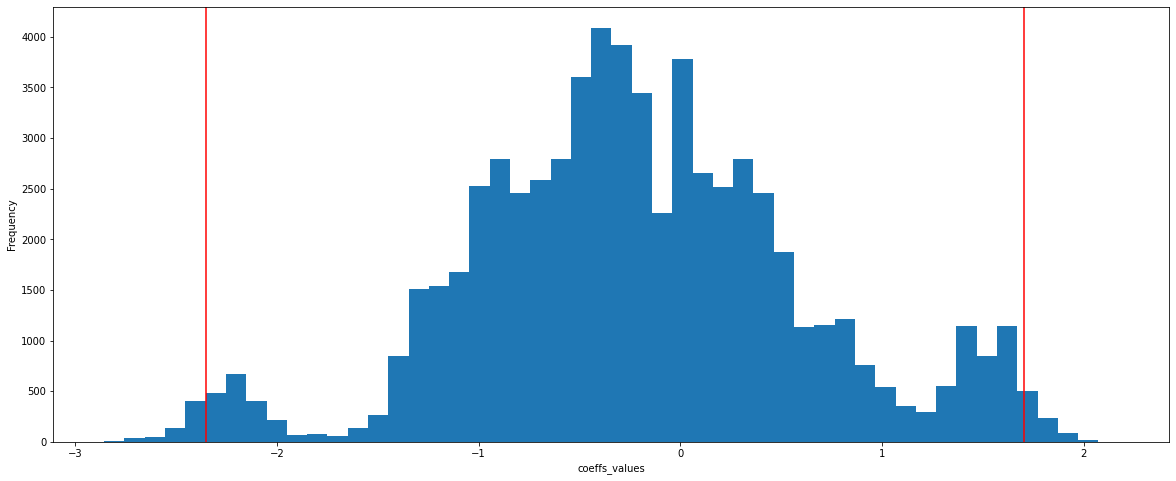

In [56]:
plt.figure(figsize=(20,8))
q_1=pd.Series(lt_coefs).quantile(.01)
q_99=pd.Series(lt_coefs).quantile(.99)

pd.Series(lt_coefs).sort_values(ascending=False).plot(kind='hist',bins=50)
plt.axvline(x=q_1,color='red')
plt.axvline(x=q_99,color='red')

plt.xlabel('coeffs_values')

In [4]:
def generate_sigma_obj(df,only_return_xy=False):
  '''
  The function will extract feature and target based columns from the provided 
  dataframe.
  Following it will formulate both sigma and linear objective based matrices.
  A constant column vector is appended to the end of the predictor covariance 
  matrix in order to incorporate the contribution of intercept.

  Slicing property of numpy was utilized to include remaining decision variables
  in the objective matrix
  
  Input=df
  Output=Sigma and linear objective that can directly passed to gurobi model

  Only processed x and y matrices can be returned by using alteranate 
  only_return_xy boolean.
  '''
  x=df.drop(['y'],axis=1).values
  y=df['y'].values

  predictors=x.shape[1]

  x=np.concatenate([x,np.ones(shape=(x.shape[0],1))],axis=1)

  if only_return_xy:
    return (x,y)
  
  sigma=np.zeros(shape=(2*predictors+1,2*predictors+1))
  sigma[:predictors+1,:predictors+1]=x.T@x


  obj=np.zeros(
      shape=(2*predictors+1)
  )
  obj[:predictors+1]=-2*(y.T@x)


  return (sigma,obj)


In [6]:
def prepare_constraint_matrix(K=10,M=20):
  '''
  This function helps to formulate constraint based matrix
  There are two types of constraint in this problem, one associated with Big M
  bounds that aids to link the value of decision variable and coefficient.

  Second one deals with restricting the number of predictors that can be used.

  Input :-
  K= Number of predictors allowed
  M= bound value for Big M constraints 

  Output :-
  A=LHS side of the constraint/ constraint matrix, dtype=array
  b=RHS side of the constraint
  sense= equality/inequality sign
  '''
  global predictors

  A=np.zeros((2*predictors+1,
              2*predictors+1))
  b=np.zeros((2*predictors+1))

  sense=np.array(['']*(2*predictors+1))

  rw=0
  for i in range(predictors):
    A[rw,[i,i+predictors+1]]=[1,-M]#upper bound for bj <M*zj
    sense[rw]='<'

    A[rw+predictors,[i,i+predictors+1]]=[1,M]#lower bound bj >M*zj
    sense[rw+predictors]='>'
    rw+=1

  A[-1,predictors+1:]=[1]*predictors
  b[-1]=K
  sense[-1]='<'

  return (A,b,sense)

In [7]:
def formulate_bounds_vtypes(M):
  '''
  Determine the upper and lower bounds of the variables
  Additionally generates and returns the variable type of decision variables
  '''
  global predictors
  ub=[M]*predictors +[M*1000] +[1]*predictors
  lb=[-M]*predictors +[-M*1000] +[0]*predictors

  vtype=['C']*(predictors+1) +['B']*(predictors)

  return (ub,lb,vtype)

In [8]:
def optimize_loss(sigma,obj,A,b,sense,vtype,ub,lb):
  '''
  This is a caller function performing optimization
  It initiates the instances of gurobipy model following assembles all the 
  associated objectives ans constraints and methodically execute them to 
  find optimal solution for provided objective function.

  Input= objective (sigma-Q,obj-L), constraint matrices(A,b,sense),vtype
  Output= Trained instance of gurobi model
  '''

  biMod = gp.Model()
  biMod_x = biMod.addMVar(len(obj),vtype=vtype,ub=ub,lb=lb) # vtype can be: 'C' or 'I' or 'B'
  biMod_con = biMod.addMConstrs(A, biMod_x, sense, b)
  biMod.setMObjective(sigma,obj,0,sense=gp.GRB.MINIMIZE)

  biMod.Params.OutputFlag = 0 
  biMod.optimize()

  return biMod

In [9]:
def compute_loss(biMod,df_test,return_weight=False):
  '''
  Input= bimod- Trained instance of gurobi that comprises of weights
  df_test= Dataframe consisting of predictirs and target variables

  Output = MSE based error 
  '''
  global predictors
  x_test=df_test.drop(['y'],axis=1).values
  y_test=df_test['y'].values

  x_test=np.concatenate([x_test,np.ones(shape=(x_test.shape[0],1))],axis=1)

  y_pred=x_test[:,:predictors+1]@biMod.x[:predictors+1]
  err=mse(y_test,y_pred)

  if return_weight:
    return (err,biMod.x[:predictors+1])
  return err





In [10]:
big_m=20
number_predictors_allowed=10
predictors=df.shape[1]-1


def perform_10fold_cv(number_predictors_allowed,big_m=20):
  '''
  This will create 10 splits of dataframe that we wish to run our CV experiment on
  Shuffle based boolean will rearrange the indices of the dataset before creating splits

  Input = number of predictors allowed (int), that will be used in our constraint matrix
  Big_m= bound values

  Output= List of 10 MSE errors  
  '''

  k_fold=KFold(n_splits=10,shuffle=True)



  lt_mse=[]
  for train_idx,test_idx in k_fold.split(df):
    df_train=df.loc[train_idx]
    df_test=df.loc[test_idx]

    sigma,obj=generate_sigma_obj(df_train)
    A,b,sense=prepare_constraint_matrix(K=number_predictors_allowed,M=big_m)
    ub,lb,vtype=formulate_bounds_vtypes(M=big_m)
    biMod=optimize_loss(sigma,obj,A,b,sense,vtype,ub,lb)
    err=compute_loss(biMod,df_test,return_weight=False)

    lt_mse.append(err)
  return lt_mse




In [ ]:
dict_k={}

for k in np.arange(5,55,5):
  print(f'processing for {k} predictors','\n\n')

  temp_lt=perform_10fold_cv(number_predictors_allowed=k)
  dict_k[str(k)]=temp_lt

processing for 5 predictors 


Restricted license - for non-production use only - expires 2023-10-25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Mod

processing for 10 predictors 




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Deprecated, use Model.addMConstr() instead


In [61]:
# pd.DataFrame(dict_k)#.to_csv('err.csv')
# df_err=pd.DataFrame(dict_k)
df_err=pd.read_csv('err.csv',index_col=0)

num_predictors=int(df_err.columns[df_err.mean().argmin()])




Text(159.0, 0.5, 'CV_set')

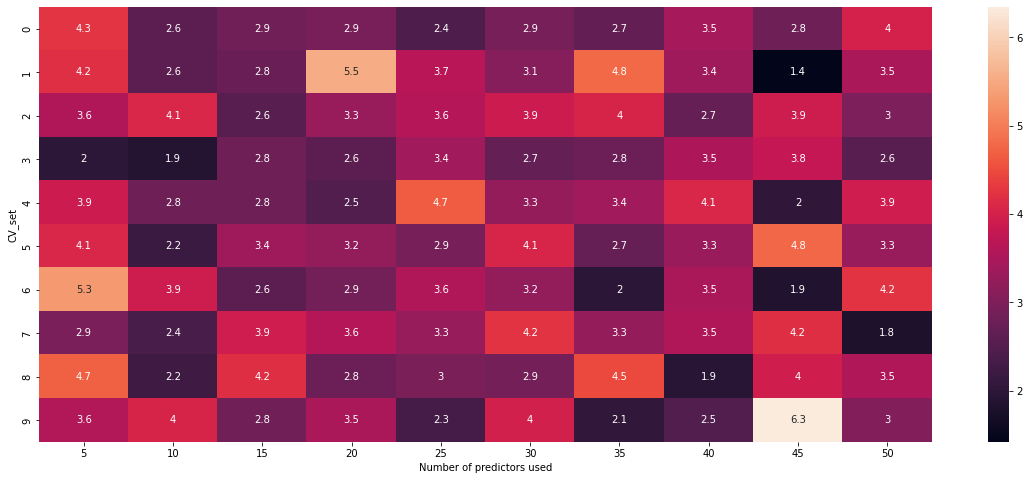

In [63]:
plt.figure(figsize=(20,8))
sns.heatmap(df_err,annot=True)
plt.xlabel('Number of predictors used')
plt.ylabel('CV_set')

In [ ]:
sigma,obj=generate_sigma_obj(df)
A,b,sense=prepare_constraint_matrix(K=num_predictors,M=big_m)
ub,lb,vtype=formulate_bounds_vtypes(M=big_m)
biMod=optimize_loss(sigma,obj,A,b,sense,vtype,ub,lb)

df_wts=pd.DataFrame(biMod.x[:predictors+1],columns=['wts'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  after removing the cwd from sys.path.


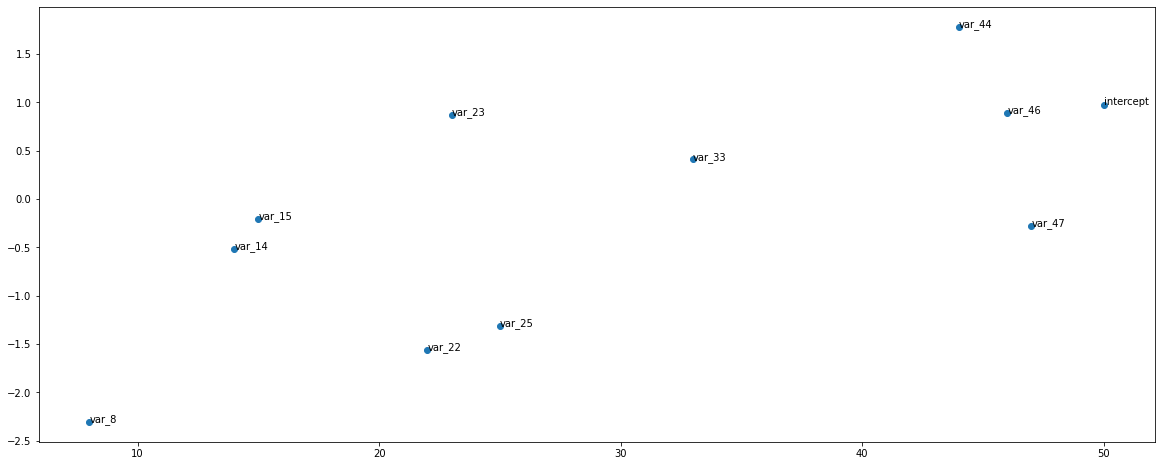

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
len(df_wts[df_wts.wts!=0])#Number of allowed preditors plus the constant 
df_wts.loc[:,'indicator']=df_wts.wts.apply(lambda e : e if e!=0 else np.nan)
plt.plot(df_wts.indicator,'o')

names=['var_'+str(i) for i in range(50)]+['intercept']
for i,nm in enumerate(names):
  if df_wts.iloc[i].wts!=0:
    plt.annotate(nm,(i,df_wts.wts[i]))



In [ ]:
df_test=pd.read_csv('test_data.csv')
x_test=df_test.drop(['y'],axis=1).values
y_test=df_test['y'].values

x_test=np.concatenate([x_test,np.ones((x_test.shape[0],1))],axis=1)


(50, 51)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'True_values')

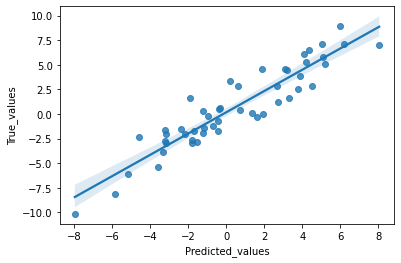

In [ ]:
wts=df_wts.wts.values
y_pred=x_test@wts
import seaborn as sns
s=sns.regplot(y_pred,y_test)#,'o')
s.set_xlabel('Predicted_values')
s.set_ylabel('True_values')

In [ ]:
mse(y_test,y_pred)

2.336543964552526

# LASSO CV

Need to run 10 cv fold based lasso to determine the optimal value of lambda which can help us further determine how many predictors were finally used by the LAsso model.

In [ ]:
x_train,y_train=generate_sigma_obj(df,only_return_xy=True)

In [ ]:
from sklearn.linear_model import LassoCV 
l_cv=LassoCV(cv=10)
l_cv.fit(x_train,y_train)



LassoCV(cv=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'True_values')

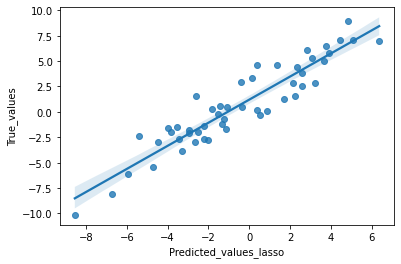

In [ ]:
l_cv.alpha_
wts_lasso=l_cv.coef_

y_pred_lasso=x_test@wts_lasso
s=sns.regplot(y_pred_lasso,y_test)#,'o')
s.set_xlabel('Predicted_values_lasso')
s.set_ylabel('True_values')



In [ ]:
mse(y_pred_lasso,y_test)

3.5947145732958834

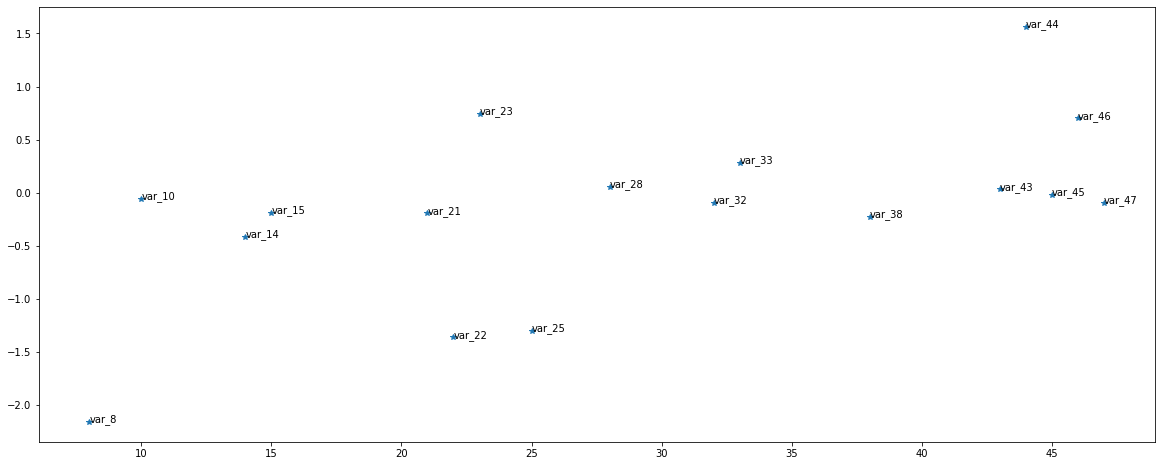

In [ ]:
# for i,wt in enumerate()
wts_lasso=np.array(wts_lasso)
beta_lasso=np.where(wts_lasso==0,np.nan,wts_lasso)
plt.figure(figsize=(20,8))
plt.plot(beta_lasso,'*')

for i,wt in enumerate(beta_lasso):
  if wt:
    nm='var_'+str(i)
    if i==len(beta_lasso)-1:
      nm='intercept'
    plt.annotate(nm,
                 (i,beta_lasso[i]))


# Rough Work
## Constraints

In [13]:
x=df.drop(['y'],axis=1).values
y=df['y'].values#.reshape(-1,1)

x=np.concatenate([x,np.ones(shape=(x.shape[0],1))],axis=1)

#We have an alzebraic formulation for all the predictors and intercept, we need to incorporate z based pivot variables in our loss function
#This needs to be done beacus eof the design of scipy optimization instance that requires variable to be of fixed length in our constraint and loss function

expanded_loss_term1=np.zeros(shape=(2*predictors+1,2*predictors+1))
expanded_loss_term1[:predictors+1,:predictors+1]=x.T@x


expanded_loss_term2=np.zeros(
    shape=(2*predictors+1)
)
expanded_loss_term2[:predictors+1]=-2*(y.T@x)

#Thus we have formulated two terms for our loss function

sigma=expanded_loss_term1
obj=expanded_loss_term2



In [26]:
from itertools import combinations
for pre_3 in combinations(range(51),3):
  lr=LinearRegression()
  lr.fit(x[:,pre_3],y)
  print(lr.coef_)
  

[-0.45412609 -0.37870189 -0.34359914]


In [29]:
#Finding appropriate M by computing regression coefficients of our dataset

lt_coefs=[]

lr=LinearRegression()
lr.fit(x,y)
lt_coefs.extend(lr.coef_)

for i in range(x.shape[1]):
  lr=LinearRegression()
  lr.fit(x[:,i].reshape(-1,1),y)
  lt_coefs.extend(lr.coef_)

from itertools import combinations
for pre_3 in combinations(range(51),3):
  lr=LinearRegression()
  lr.fit(x[:,pre_3],y)
  lt_coefs.extend(lr.coef_)

print(np.max(np.absolute(np.array(lt_coefs))))
# Our starting M can be--> 100 >>2.8*10
M=np.round(np.max(np.absolute(np.array(lt_coefs)))*10,-2)
# M=20

print(np.min(np.absolute(np.array(lt_coefs))))


2.855970818913819
0.0


In [31]:
M=np.round(np.max(np.absolute(np.array(lt_coefs)))*10,2)
M

28.56

In [ ]:
#Big M constraints for every predictor
#2* preditors number of constraints
#Orientation of the decision variables - preditors + intercept + gates(decision variables)

#1 constraint for z number of variables

K=25

A=np.zeros((2*predictors+1,
            2*predictors+1))
b=np.zeros((2*predictors+1))

sense=np.array(['']*(2*predictors+1))

rw=0
for i in range(predictors):
  A[rw,[i,i+predictors+1]]=[1,-M]#upper bound for bj <M*zj
  sense[rw]='<'

  A[rw+predictors,[i,i+predictors+1]]=[1,M]#lower bound bj >M*zj
  sense[rw+predictors]='>'

  rw+=1

A[-1,predictors+1:]=[1]*50
b[-1]=K
sense[-1]='<'

ub=[M]*50 +[M*1000] +[1]*50
lb=[-M]*50 +[-M*1000] +[0]*50

vtype=['C']*(predictors+1) +['B']*50

NameError: ignored

In [ ]:
vtype=['C']*51 +['B']*50
# obj

In [ ]:
biMod = gp.Model()
biMod_x = biMod.addMVar(len(obj),vtype=vtype,ub=ub,lb=lb) # vtype can be: 'C' or 'I' or 'B'
# biMod_con = biMod.addMConstrs(A, biMod_x, sense, b)
# biMod.setMObjective(sigma,obj,0,sense=gp.GRB.MINIMIZE)

# biMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
# biMod.optimize()

AssertionError: ignored

In [ ]:
(x[:,:predictors+1]@biMod.x[:predictors+1]).shape

(250,)

In [ ]:
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,train_size=0.8)

predictors=df.shape[1]-1

number_predictors_allowed=10
big_m=20




sigma,obj=generate_sigma_obj(df_train)
A,b,sense=prepare_constraint_matrix(K=number_predictors_allowed,M=big_m)
ub,lb,vtype=formulate_bounds_vtypes(M=big_m)
biMod=optimize_loss(A,b,sense,vtype,ub,lb)
err=compute_loss(biMod,df_test,return_weight=False)





